# Decision Tree Iris Dataset Example

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from xgboost.sklearn import XGBClassifier
from scipy.stats import uniform, truncnorm, randint
from itertools import compress

from pprint import pprint

import pandas as pd
import numpy as np

from dtreeviz.trees import dtreeviz
import matplotlib.pyplot as plt
%matplotlib inline

The data are from the [UCI ML repository](https://archive.ics.uci.edu/ml/datasets/wine+quality).
<br>
<br>
They contain information about chemical and sensory characteristics of wines as well as a rating of the quality of the wine.
<br>
<br>
I'm only going to use this dataset to provide an example of how to construct a randomized search to tune hyperparameters using sci-kit learn's `Pipeline` function. There is much more you could do with this dataset, and if you were actually going to construct a proper model you'd want to do EDA, data cleaning, and do some class balancing of course!

##### Read in the data

In [ ]:
## red and white wine are stored in separate csvs
red_wine = pd.read_csv('winequality-red.csv', sep=';')
white_wine = pd.read_csv('winequality-white.csv', sep=';')
## concatenate into single df
wines = pd.concat([red_wine,white_wine])
## look at data
wines.head()

The class label column is the quality' column. It's currently an ordinal multiclass label (quality rating between 0-10 with 0 being worst 10 being best). For simplicity I'm just going to turn this into a binary class label with all values less than or equal to five categorized as 'bad' quality and anything with a rating higher than five as 'good' quality. 

In [ ]:
## create new binary class labels
wines['quality_category'] = np.where(wines.quality<=5, 'bad', 'good')
## drop the old labels
wines.drop(['quality'], axis=1, inplace=True)

##### Train-test split

In [ ]:
## features
X = wines.iloc[:,:-1]
## label
y = wines.quality_category
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Begin Pipeline

Basic pipeline steps with hyperparameter tuning are:<br>
<br>
1) define the models to fit

2) define the hyperparameters to search over for each model

3) put together using the `Pipeline` function

4) compare results of all fitted models with tuned hyperparameters

##### 1) Define models

Since we are talking about decision trees, random forests, and XGBoost today we will fit these three models

In [ ]:
## define the models to fit
base_models = [DecisionTreeClassifier(random_state=42),
               RandomForestClassifier(random_state=42),
               XGBClassifier(random_state=42)]

##### 2) Define the hyperparameters

As you know, each model has many hyperparameters you can tune. There are also a couple of options for how to tune the hyperparameters - grid search and randomized search.
<br>
<br>
With grid search, the user specifically defines which values the hyperparameters will take, with random search, the user defines a random distribution for the search to pass over and the user can define what distribution the hyperparameters should take. 
<br>
<br>
In order to feed the parameters into the pipeline, they need to have the model name as a prefix before the hyperparameter name, separated by a dunder (e.g. `clf__criterion`)

In [ ]:
# define models to test:
check_params_dtree = {'clf__criterion':['gini', 'entropy'],
                   'clf__max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
                   'clf__min_samples_split': uniform(0.01, 0.199),
                   'clf__max_depth':randint(1,10)}

check_params_rf = {'clf__criterion':['gini', 'entropy'],
                   'clf__n_estimators': randint(4,200),
                   'clf__max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
                   'clf__min_samples_split': uniform(0.01, 0.199),
                   'clf__max_depth':randint(3,15)}

check_params_xgb = {'clf__max_depth':randint(3,15),
                    'clf__n_estimators':randint(4,200),
                    'clf__learning_rate':uniform(0.01,0.199)
                   }

## save parameter spaces in a list
check_params = [check_params_dtree, check_params_rf, check_params_xgb]

##### 3) Put together in the pipeline function

The pipeline function can have many more steps than what is presented here. Each step should be given a name (e.g. `('sc1', StandardScaler())`). You can put all sorts of stuff in the pipeline, but here I just put the scaling function because it was simple and all of the datasets features are numeric. I don't know if the data actually need this part or if this is the best scaling factor to fit but it's just an example. 

In [ ]:
def modelFit(clf, params, X_train, y_train, X_test, y_test):
    """A model to fit the pipeline for a predefined model (clf) using a randomized search
    cross validation to tune the hyperparameters (params:dict of predefined hyperparams to search).
    Returns the model and a classification report of the model"""
    
    pipe = Pipeline(steps=[('sc1', StandardScaler()),
                          ('clf', clf)])
    
    random_search = RandomizedSearchCV(pipe,
                                      params,
                                      n_iter=100,
                                      cv=5,
                                      random_state=42)
    
    model_out = random_search.fit(X_train, y_train)
    
    y_true, y_pred = y_test, model_out.predict(X_test)
    
    classification_rep = classification_report(y_true, y_pred)
    
    return model_out, classification_rep

##### 4) Fit and compare the models

Now we can put it all together and compare our models with the tuned hyperparameters using the classification reports for each model.

In [193]:
### empty spaces to save the models and classification reports
fitted_models = []
classification_reps = []

## run the model for each respective pair of models and hyperparameter dicts
for mod, param in zip(base_models, check_params):
    one_mod, one_classification = modelFit(mod, param, X_train, y_train, X_test, y_test)
    fitted_models.append(one_mod)
    classification_reps.append(one_classification)

## print the classification reports    
[print(x) for x in classification_reps]

From the classification report you can see that the, based on the F1 score, the XGBoost model fits the best. However, remember that we didn't clean or balance these data...so, don't draw any conclusions from this!

## Decision Tree Visualization Examples
<br>

### For funsies

<br>
If your data has a lot of features, especially a lot of numeric features, it can be too unweildly to visualize a tree. But if your n features is relatively small you can make a neat visualization.
<br>
<br>
The wine dataset is a little much for this visualization, but the comparitively simple iris dataset provides a nice example

In [4]:
# Prepare the data data
iris = load_iris()
X = iris.data
y = iris.target
# Fit the classifier with default hyper-parameters
clf = DecisionTreeClassifier(random_state=42)
model = clf.fit(X, y)

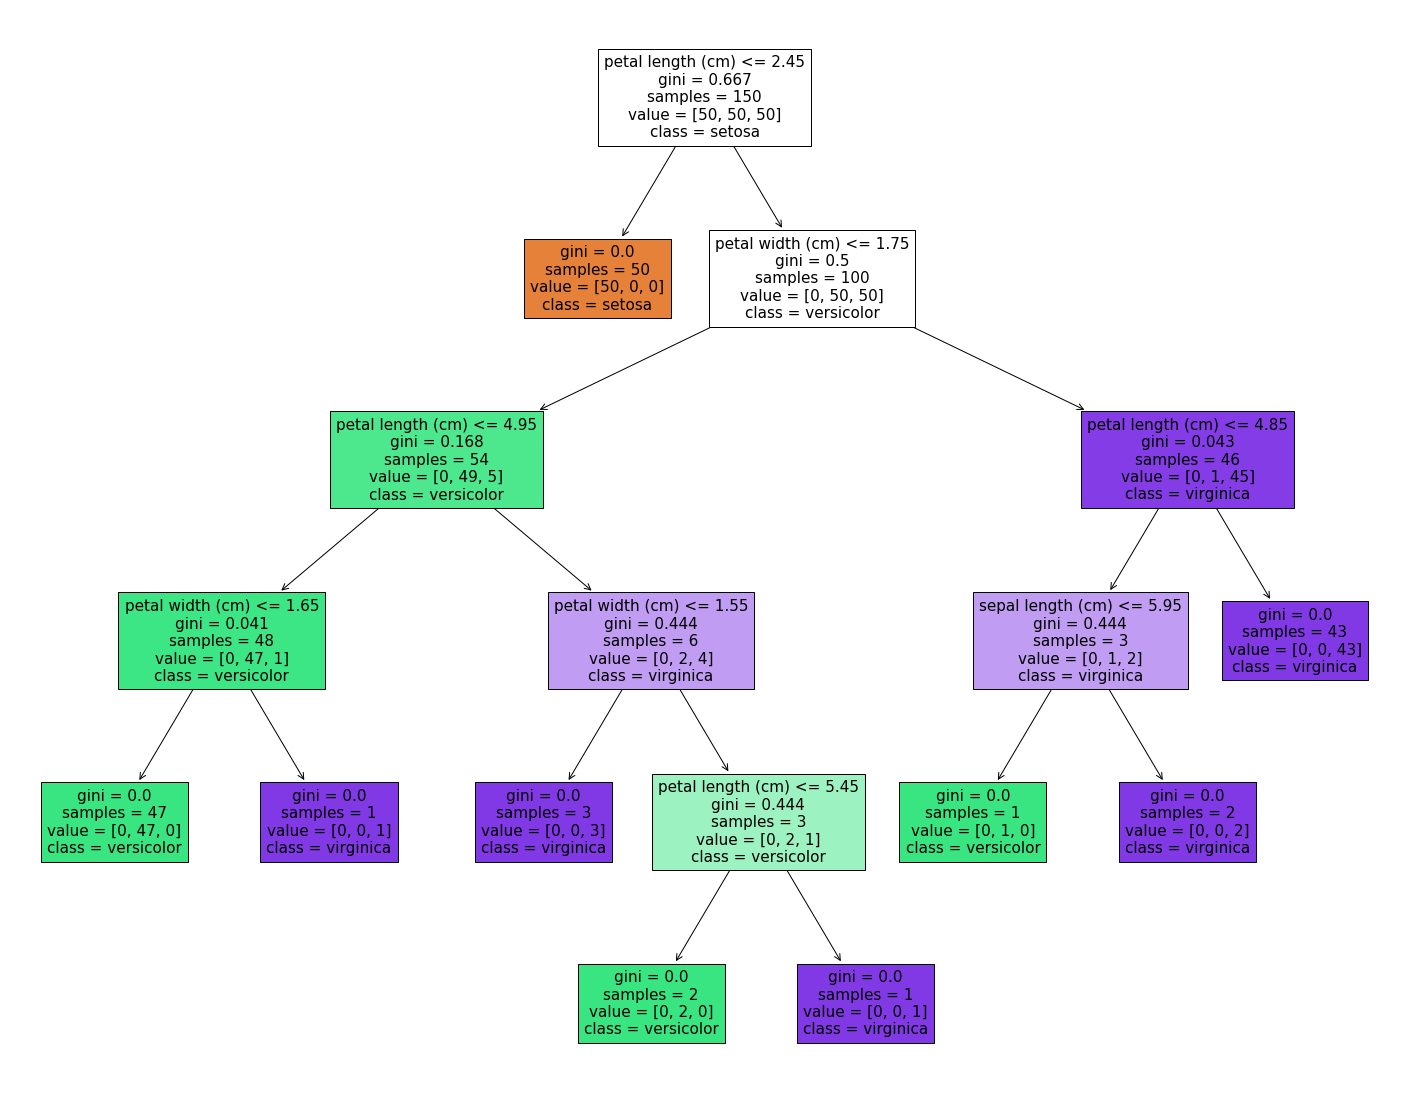

In [6]:
fig = plt.figure(figsize=(25,20))
vis_tree = tree.plot_tree(clf, 
                   feature_names=iris.feature_names,  
                   class_names=iris.target_names,
                   filled=True)

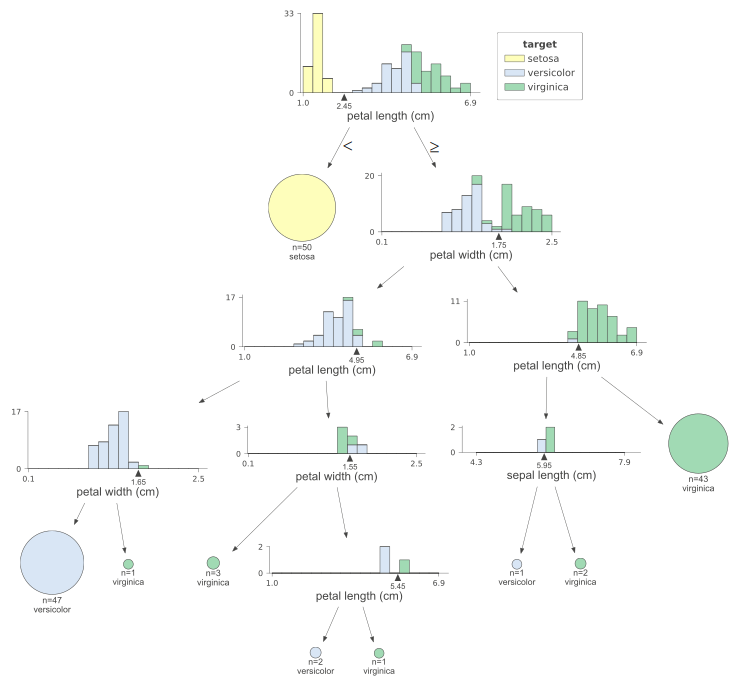

In [5]:
viz = dtreeviz(clf, X, y,
                target_name="target",
                feature_names=iris.feature_names,
                class_names=list(iris.target_names),
                scale = 1.3)
viz

In [ ]:
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Categorical.from_codes(iris.target, iris.target_names)
## create the model
clf = DecisionTreeClassifier()
## fit the model
clf.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
vis_tree = tree.plot_tree(dt, 
                   feature_names=iris.feature_names,  
                   class_names=iris.target_names,
                   filled=True)

In [34]:
## load dataset


In [35]:
## look at it
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [36]:
## look at labels
set(y)

{'setosa', 'versicolor', 'virginica'}

Multi-class problem
<br>
Will code each class label as a numeric (for ease of confusion matrix creation)
<br>
setosa=0, versicolor=1, virginica=2

In [115]:
## code each class label
y = pd.get_dummies(y)

Train test split for making and evaluating the model

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Fit the DecisionTreeClassifier()

In [117]:
## create the model
dt = DecisionTreeClassifier()
## fit the model
dt.fit(X_train, y_train)

DecisionTreeClassifier()

Visualize the Decision Tree using `plot_tree`

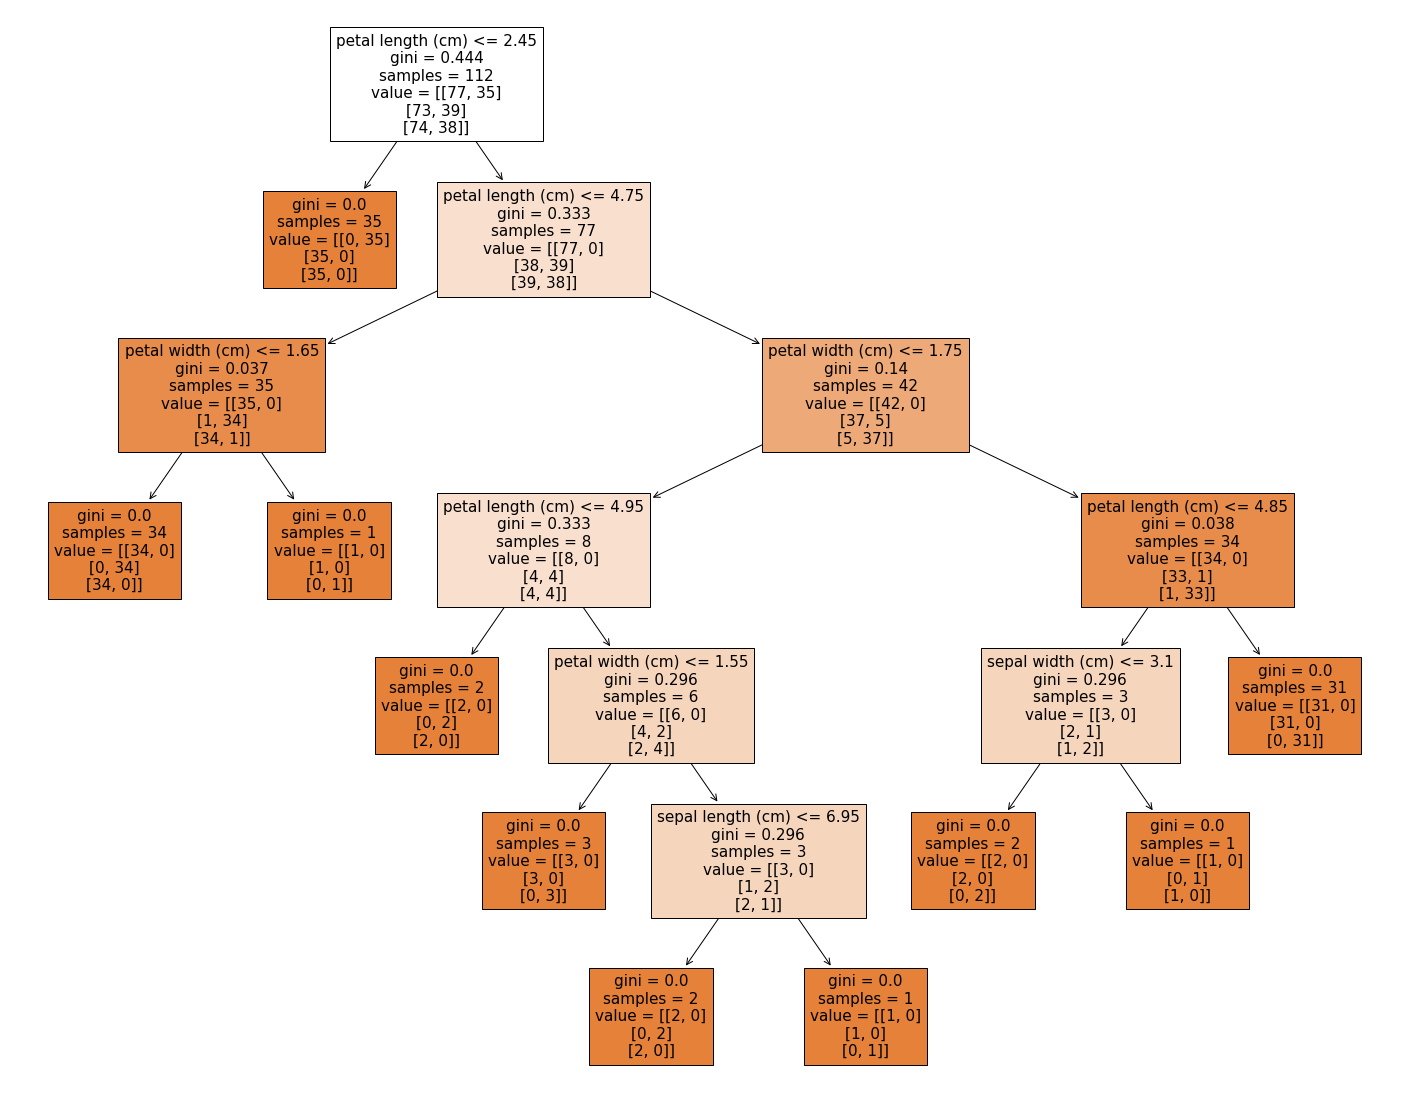

In [119]:
fig = plt.figure(figsize=(25,20))
vis_tree = tree.plot_tree(dt, 
                   feature_names=iris.feature_names,  
                   class_names=iris.target_names,
                   filled=True)

Evaluate the tree

In [120]:
## get predicted values
y_pred = dt.predict(X_test)

In [121]:
## confusion matrix
species = np.array(y_test).argmax(axis=1)
predictions = np.array(y_pred).argmax(axis=1)
confusion_matrix(species, predictions)
## anything outside of the diagonal is an incorrect classification
## anything on the diagonal is correct

array([[15,  0,  0],
       [ 0, 11,  0],
       [ 0,  0, 12]])

No incorrectly classified species wow neat

Alternate visualization using `dtreeviz`

In [122]:
# Prepare the data data
iris = load_iris()
X = iris.data
y = iris.target
# Fit the classifier with default hyper-parameters
clf = DecisionTreeClassifier(random_state=42)
model = clf.fit(X, y)

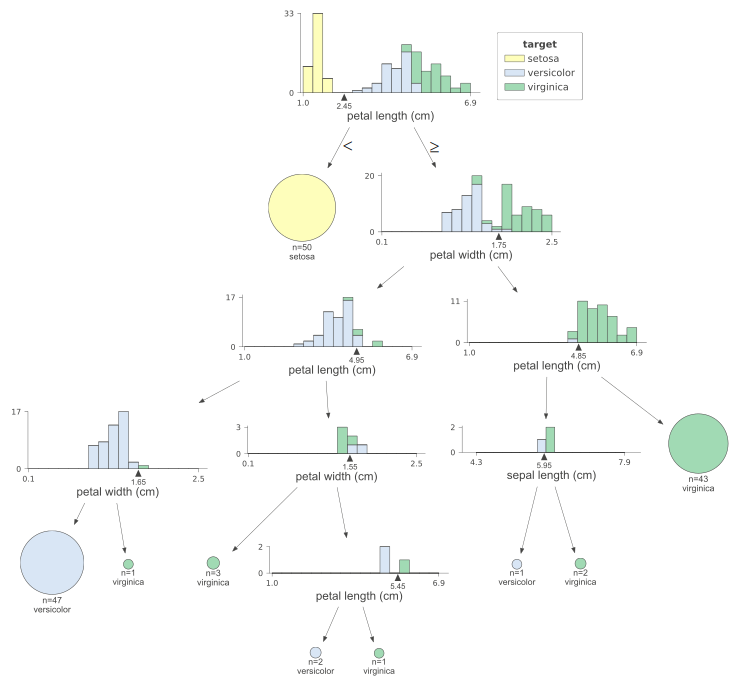

## XGBoost Attempt

https://www.kaggle.com/justindeed/iris-with-xgboost-and-gridsearchcv

In [129]:
iris = load_iris()

X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [130]:
param_grid = {
        'max_depth': [1, 2, 3, 4],
        'n_estimators': [4, 5, 6],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 1],
                }

In [131]:
clf = XGBClassifier()

## grid search important arguments are 
## 1) the model you are training
## 2) the parameter grid you are searching
## 3) the number of cross validation folds for training the models
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [132]:
print ('Best parameters:', grid_search.best_params_)
print ('Best estimator:', grid_search.best_estimator_)
print ('Best score:', grid_search.best_score_)

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 4}
Best estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=4, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Best score: 0.9636363636363636


In [133]:
grid_search.predict(X_test)

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0])

## Random Forest

https://jamesrledoux.com/code/grid_search

In [134]:
model_params = {
    'n_estimators': [50, 150, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 4, 6]
}

In [ ]:
# create random forest classifier model
clf = RandomForestClassifier(random_state=42)

# set up grid search meta-estimator
grid_search = GridSearchCV(clf, model_params, cv=5)

# train the grid search meta-estimator to find the best model
model = grid_search.fit(X, y)

In [140]:
# print winning set of hyperparameters

pprint(model.best_estimator_.get_params())
pprint(model.best_score_)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
0.9666666666666668


In [141]:
# generate predictions using the best-performing model
predictions = model.predict(X)
print(predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


Random search for parameters as from:

https://jamesrledoux.com/code/randomized_parameter_search

In [153]:
model_params = {
    # randomly sample numbers from 4 to 204 estimators
    'n_estimators': randint(4,200),
    # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    'min_samples_split': uniform(0.01, 0.199),
    
    'criterion':['gini', 'entropy'],
    
    'max_depth':randint(3,15)
}

The most important arguments to pass to RandomizedSearchCV are the model you’re training, the dictionary of parameter distributions, the number of iterations for random search to perform, and the number of folds for it to cross validate over.

The total number of models random search trains is then equal to `n_iter * cv`



In [154]:
# create random forest classifier model
clf = RandomForestClassifier(random_state = 42)

# set up random search meta-estimator
# this will train 100 models over 5 folds of cross validation (500 models total)
random_search = RandomizedSearchCV(clf, model_params, n_iter=100, cv=5, random_state=42)

# train the random search meta-estimator to find the best model out of 100 candidates
model = random_search.fit(X, y)

# print winning set of hyperparameters

pprint(model.best_estimator_.get_params())
pprint(round(model.best_score_, 2))

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 0.2891219948329566,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 0.029895008247782573,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 91,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
0.97


In [147]:
# generate predictions using the best-performing model
predictions = model.predict(X)
print(predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [150]:
clf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

## Pipe

In [156]:
clf = XGBClassifier(random_state = 42)
clf.get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [157]:
clf = RandomForestClassifier(random_state=42)
clf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [161]:
# define models to test:
base_models = [("clf", DecisionTreeClassifier(random_state=42)),
               ("clf", RandomForestClassifier(random_state=42)),
               ("clf", XGBClassifier(random_state=42))]

In [162]:
check_params_dtree = {'pca__n_components':randint(2,6),
                      'clf__criterion':['gini', 'entropy'],
                      'clf__max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
                      'clf__min_samples_split': uniform(0.01, 0.199),
                      'clf__max_depth':randint(3,15)}

check_params_rf = {'pca__n_components':randint(2,6),
                   'clf__criterion':['gini', 'entropy'],
                   'clf__n_estimators': randint(4,200),
                   'clf__max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
                   'clf__min_samples_split': uniform(0.01, 0.199),
                   'clf__max_depth':randint(3,15)}

check_params_xgb = {'pca__n_components':randint(2,6),
                    'clf__max_depth':randint(3,15),
                    'clf__n_estimators':randint(4,200),
                    'clf__learning_rate':uniform(0.01,0.199)
                   }

check_params = [check_params_dtree, check_params_rf, check_params_xgb]

In [ ]:
def model_fit(model, params, X_train, y_train, X_test, y_test):
    
    pipe = Pipeline([('sc1', StandardScaler()),
                     ('pca', PCA()),
                    model])
    
    gs = GridSearchCV(estimator = pipe,
                     param_grid = params,
                     scoring = 'accuracy',
                     cv = 5)
    
    gs.fit(X_train, y_train)
    
    # evaluate the model on the test set
    y_true, y_pred = y_test, gs.predict(X_test)

    # get classification report for the gs model
    print(classification_report(y_true, y_pred))

In [171]:
def model_fit(clf, params, X_train, y_train, X_test, y_test):
    
    pipe = Pipeline([('sc1', StandardScaler()),
                     ('pca', PCA()),
                    model])
    
    RandomizedSearchCV(clf, model_params, n_iter=100, cv=5, random_state=42)
    random_search = RandomizedSearchCV(estimator = pipe,
                     param_distributions=params,
                     n_iter=100,
                     cv=5,
                     random_state=42)
    
    model = random_search.fit(X_train, y_train)
    
    # evaluate the model on the test set
    #y_true, y_pred = y_test, model.predict(X_test)

    # get classification report for the gs model
    #print(classification_report(y_true, y_pred))
    return model

In [ ]:
RandomizedSearchCV()

In [ ]:
for mod, param in zip(base_models, check_params):
    model_fit(mod, param, X_train, y_train, X_test, y_test)

In [168]:
base_models[0]

('clf', DecisionTreeClassifier(random_state=42))

In [169]:
check_params[0]

{'clf__criterion': ['gini', 'entropy'],
 'clf__max_features': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f8d354daa90>,
 'clf__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f8d354dac90>,
 'clf_max_depth': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f8d34ee43d0>}

In [174]:
#model_fit(base_models[0], check_params[0], X_train,y_train,X_test,y_test)

In [173]:
DecisionTreeClassifier().get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [182]:
clf = DecisionTreeClassifier(random_state = 42)
check_params_dtree = {'criterion':['gini', 'entropy'],
                   'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
                   'min_samples_split': uniform(0.01, 0.199),
                   'max_depth':randint(1,10)}
random_search = RandomizedSearchCV(clf, check_params_dtree, n_iter=100, cv=5, random_state=42)
model = random_search.fit(X_train, y_train)
predictions = model.predict(X)
print(predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [184]:
clf = RandomForestClassifier(random_state = 42)
check_params_rf = {'criterion':['gini', 'entropy'],
                   'n_estimators': randint(4,200),
                   'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
                   'min_samples_split': uniform(0.01, 0.199),
                   'max_depth':randint(3,15)}
random_search = RandomizedSearchCV(clf, check_params_rf, n_iter=100, cv=5, random_state=42)
model = random_search.fit(X_train, y_train)
predictions = model.predict(X)
print(predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [190]:
clf = XGBClassifier(random_state=42)
check_params_xgb = {'max_depth':randint(3,15),
                    'n_estimators':randint(4,200),
                    'learning_rate':uniform(0.01,0.199)
                   }
random_search = RandomizedSearchCV(clf, check_params_xgb, n_iter=100, cv=5, random_state=42)
model = random_search.fit(X_train, y_train)
predictions = model.predict(X)
print(predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


# Wine

In [194]:
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [195]:
set(red_wine['quality'])

{3, 4, 5, 6, 7, 8}

In [197]:
white_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [198]:
set(white_wine['quality'])

{3, 4, 5, 6, 7, 8, 9}

In [199]:
## put them together
## say anything less than or equal to 5 is bad
## anything greater than 5 is good
## drop quality column

In [209]:
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [216]:
wines['quality_category'] = np.where(wines.quality<=5, 'bad', 'good')
wines.drop(['quality'], axis=1, inplace=True)

In [217]:
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_category
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,bad
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,bad
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,good
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,bad


In [224]:
clf = DecisionTreeClassifier(random_state = 42)
check_params_dtree = {'criterion':['gini', 'entropy'],
                   'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
                   'min_samples_split': uniform(0.01, 0.199),
                   'max_depth':randint(1,10)}
random_search = RandomizedSearchCV(clf, check_params_dtree, n_iter=100, cv=5, random_state=42)
model = random_search.fit(X_train, y_train)
predictions = model.predict(X_test)
# evaluate the model on the test set
y_true, y_pred = y_test, predictions
# get classification report for the gs model
print(classification_report(y_true, y_pred))

In [226]:
clf = RandomForestClassifier(random_state = 42)
check_params_rf = {'criterion':['gini', 'entropy'],
                   'n_estimators': randint(4,200),
                   'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
                   'min_samples_split': uniform(0.01, 0.199),
                   'max_depth':randint(3,15)}
random_search = RandomizedSearchCV(clf, check_params_rf, n_iter=100, cv=5, random_state=42)
model = random_search.fit(X_train, y_train)
predictions = model.predict(X_test)
# evaluate the model on the test set
y_true, y_pred = y_test, predictions
# get classification report for the gs model
print(classification_report(y_true, y_pred))

['good' 'bad' 'good' ... 'good' 'bad' 'good']


In [228]:
clf = XGBClassifier(random_state=42)
check_params_xgb = {'max_depth':randint(3,15),
                    'n_estimators':randint(4,200),
                    'learning_rate':uniform(0.01,0.199)
                   }
random_search = RandomizedSearchCV(clf, check_params_xgb, n_iter=100, cv=5, random_state=42)
model = random_search.fit(X_train, y_train)
predictions = model.predict(X_test)
# evaluate the model on the test set
y_true, y_pred = y_test, predictions
# get classification report for the gs model
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         bad       0.74      0.72      0.73       584
        good       0.85      0.86      0.85      1041

    accuracy                           0.81      1625
   macro avg       0.79      0.79      0.79      1625
weighted avg       0.81      0.81      0.81      1625



In [ ]:
## i want the model pipeline to output a list of models and a list of classification reports
## i want the model to include pca and the standard scaler steps

lay pipe

In [265]:
clf_dtree = DecisionTreeClassifier(random_state=42)
check_params_dtree = {'clf__criterion':['gini', 'entropy'],
                   'clf__max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
                   'clf__min_samples_split': uniform(0.01, 0.199),
                   'clf__max_depth':randint(1,10)}
temp, class_temp = modelFit(clf_dtree, check_params_dtree, X_train, y_train, X_test, y_test)

In [269]:
clf_rf = RandomForestClassifier(random_state=42)
check_params_rf = {'clf__criterion':['gini', 'entropy'],
                   'clf__n_estimators': randint(4,200),
                   'clf__max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
                   'clf__min_samples_split': uniform(0.01, 0.199),
                   'clf__max_depth':randint(3,15)}
temp, class_temp = modelFit(clf_rf, check_params_rf, X_train, y_train, X_test, y_test)

In [270]:
print(class_temp)

              precision    recall  f1-score   support

         bad       0.69      0.65      0.67       584
        good       0.81      0.84      0.82      1041

    accuracy                           0.77      1625
   macro avg       0.75      0.74      0.75      1625
weighted avg       0.77      0.77      0.77      1625



              precision    recall  f1-score   support

         bad       0.61      0.63      0.62       584
        good       0.79      0.78      0.78      1041

    accuracy                           0.72      1625
   macro avg       0.70      0.70      0.70      1625
weighted avg       0.73      0.72      0.73      1625

              precision    recall  f1-score   support

         bad       0.69      0.65      0.67       584
        good       0.81      0.84      0.82      1041

    accuracy                           0.77      1625
   macro avg       0.75      0.74      0.75      1625
weighted avg       0.77      0.77      0.77      1625

              precision    recall  f1-score   support

         bad       0.74      0.72      0.73       584
        good       0.85      0.86      0.85      1041

    accuracy                           0.81      1625
   macro avg       0.79      0.79      0.79      1625
weighted avg       0.81      0.81      0.81      1625



[None, None, None]